# Esercizio 12.2

Classification of mnist digits using a CNN

Importing required libraries (tensorflow, keras, scikit-learn, tqdm, numpy and matplotlib).
scikit-learn provides the utility "ConfusionMatrixDisplay" to assess which kind of misclassifications the models usually do.\
```utils.py``` and ```models.py``` provide some custom utilities to perform results caching, build standard models and plot results.

In [1]:
import os
import random

# prevents tensorflow from printing many useless warnings (for presentation purposes)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# scikit-learn throws errors on my machine if loaded after the others.
# It is used to plot confusion matrices
import sklearn


from ex12.utils import (
    load_history,
    save_history,
    optimize_model,
    plot_fits,
    plot_confusion_matrices,
    plot_wrong_predictions,
)
from ex12.models import make_small_cnn, make_big_cnn, load_best_weights


import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

# progressbar library
from tqdm.notebook import tqdm

random.seed(1)
tf.random.set_seed(1)

# Loading and reshaping the dataset. Reshaping could also be done on-the-fly
# through keras layers or using the tf.Data pipeline, but as long as
# the dataset fits in memory it is faster to preprocess it.
# Reshaping here consists in appending an axis to the tensor, as per requirements of keras' Conv2D layer
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.0
x_test = np.expand_dims(x_test, axis=-1) / 255.0

# The number of features: 10 digits
n_classes = 10

# Use cached data instead of recomputing
use_cache = True
# Overwrite cached data
overwrite = False

verbosity = 0


The following code performs a grid search on the hyperparameters ```optimizer``` and ```batch_size``` to assess which combinations perform the best.\
Note:
- a simpler CNN model is used to speed up calculations;
- caching is enabled by default;
- early stopping is implemented in model optimization to prevent overfitting.

In [2]:
optimizers = ["sgd", "adam", "rmsprop"]
batch_sizes = [16, 32, 128, 512]

results = {}
for optimizer in tqdm(optimizers):
    for batch_size in tqdm(batch_sizes, leave=False):
        name = f"{optimizer}_{batch_size}_cnn"
        with tf.device("/device:CPU:0"):
            model = make_small_cnn(name, input_shape=x_train.shape[1:], n_classes=10)
            history = None
            if use_cache:
                history = load_history(model)
            if history is None:
                history = optimize_model(
                    model,
                    ((x_train, y_train), (x_test, y_test)),
                    optimizer,
                    batch_size,
                    verbose=verbosity,
                    max_epochs=25,
                )
                save_history(model, history, overwrite)
            else:
                load_best_weights(model, verbosity)
        results[name] = (model, history)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

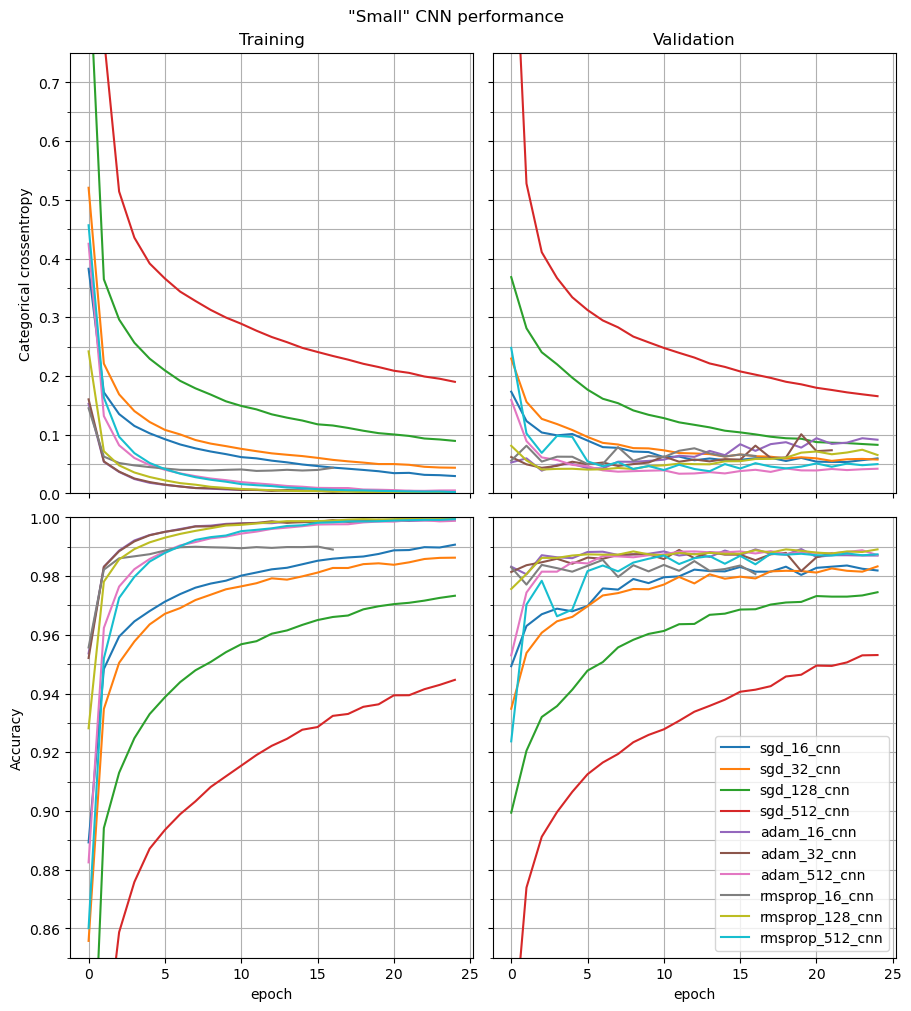

In [3]:
# Displaying training history
fig, axes = plt.subplots(
    2,
    2,
    sharex=True,
    sharey="row",
    dpi=100,
    figsize=(9, 10),
    constrained_layout=True,
)
fig.suptitle('"Small" CNN performance')
plot_fits(
    {
        name: history
        for name, (_, history) in results.items()
        # some plots are excluded to ease visualization
        if name not in ["adam_128_cnn", "rmsprop_32_cnn"]
    },
    axes,
)
axes[0, 0].set_yticks(np.arange(0.0, 0.75, 0.05), minor=True)
axes[0, 0].set_ylim(0.0, 0.75)
axes[1, 0].set_yticks(np.arange(0.75, 1.0, 0.01), minor=True)
_ = axes[1, 0].set_ylim(0.85, 1.0)


Elaborate optimizers perform better using less steps and are less sensible to the batch size. ```sgd``` instead performs significantly worse and is susceptible to the other hyperparameter. Nevertheless there seems to be room for improvements using a batch size of 128 and a number of epochs > 25.

The 3 most interesting combinations of hyperparameters are explored using a more sofisticated CNN model (2 convolutional+maxpooling layers and 2 dropout layers). The maximum number of epochs is increased to 100 to provide ```sgd``` with enough time to improve.

In [4]:
big_results = {}
combos = [("sgd", 128), ("rmsprop", 512), ("adam", 16)]
big_results = {}
for optimizer, batch_size in tqdm(combos):
    name = f"{optimizer}_{batch_size}_big_cnn"
    with tf.device("/device:CPU:0"):
        model = make_big_cnn(name, input_shape=x_train.shape[1:], n_classes=10)
        history = None
        if use_cache:
            history = load_history(model)
        if history is None:
            history = optimize_model(
                model,
                ((x_train, y_train), (x_test, y_test)),
                optimizer,
                batch_size,
                verbose=verbosity,
                max_epochs=100,
            )
            save_history(model, history, overwrite)
        else:
            load_best_weights(model, verbosity)
    big_results[name] = (model, history)


  0%|          | 0/3 [00:00<?, ?it/s]

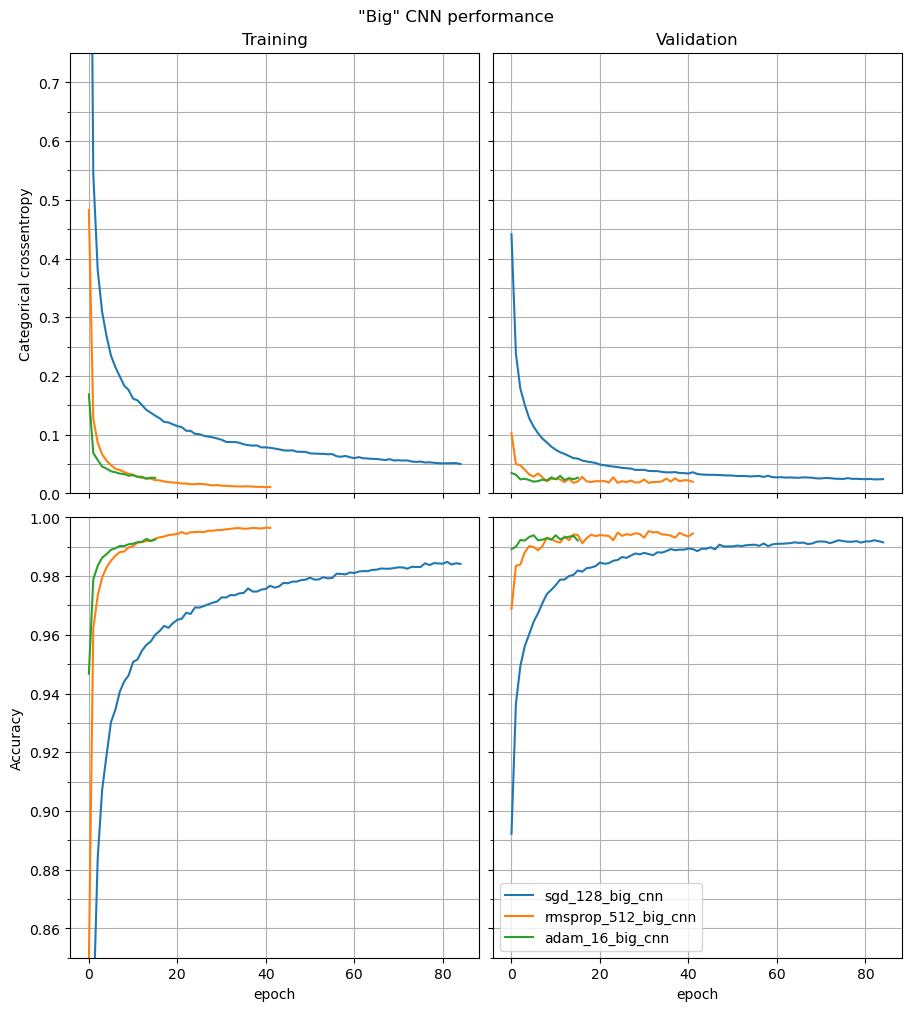

In [5]:
fig, axes = plt.subplots(
    2,
    2,
    sharex=True,
    sharey="row",
    dpi=100,
    figsize=(9, 10),
    constrained_layout=True,
)
fig.suptitle('"Big" CNN performance')
plot_fits({name: history for name, (_, history) in big_results.items()}, axes)
axes[0, 0].set_yticks(np.arange(0.0, 0.75, 0.05), minor=True)
axes[0, 0].set_ylim(0.0, 0.75)
axes[1, 0].set_yticks(np.arange(0.75, 1.0, 0.01), minor=True)
_ = axes[1, 0].set_ylim(0.85, 1.0)


The validation accuracy is increased across the board with respect to the smaller model reaching over 99% using all the optimizers. `sgd` remains the worst performing, though.

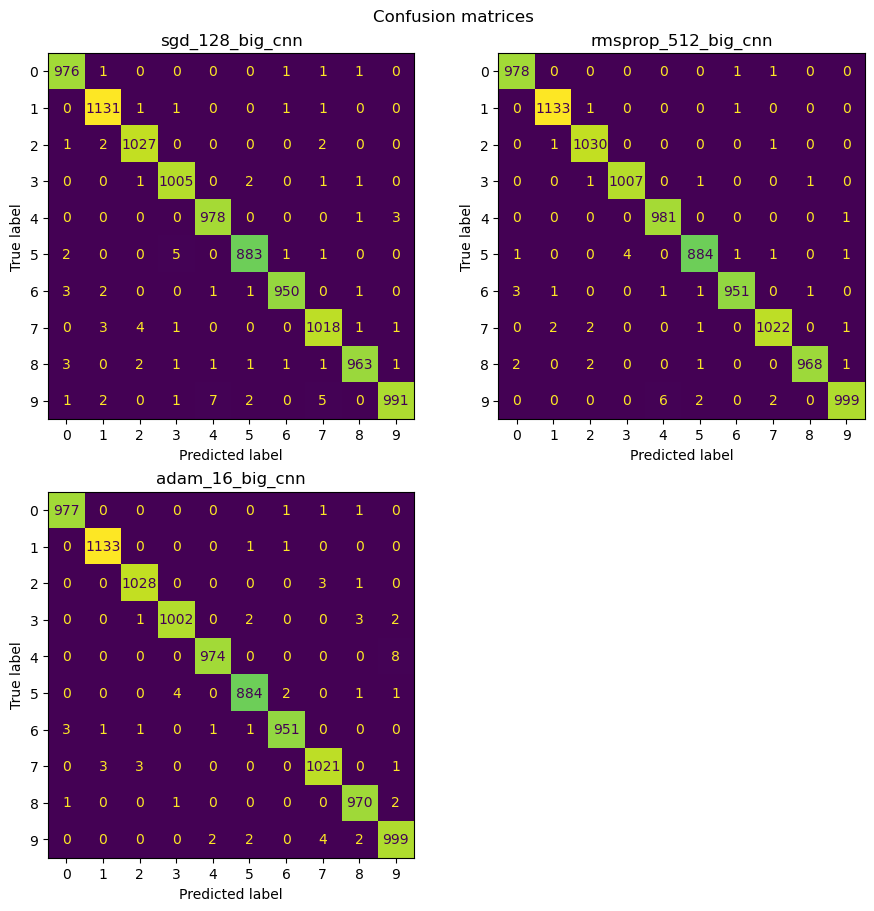

In [6]:
fig = plt.figure(figsize=(9, 9), dpi=100, constrained_layout=True)
plot_confusion_matrices(
    fig, [model for (model, _) in big_results.values()], x_test, y_test, 2, 2
)


The confusion matrix is a popular metric to assess a classifier's performance. It can be seen that the models mistake numbers that are similarly written (e.g. '4' with '9' and '2' with '7' and viceversa)

Below some examples of digits misclassified using the best performing hyperparameters are reported. Some of them would arguably be difficult to get right even for a human.

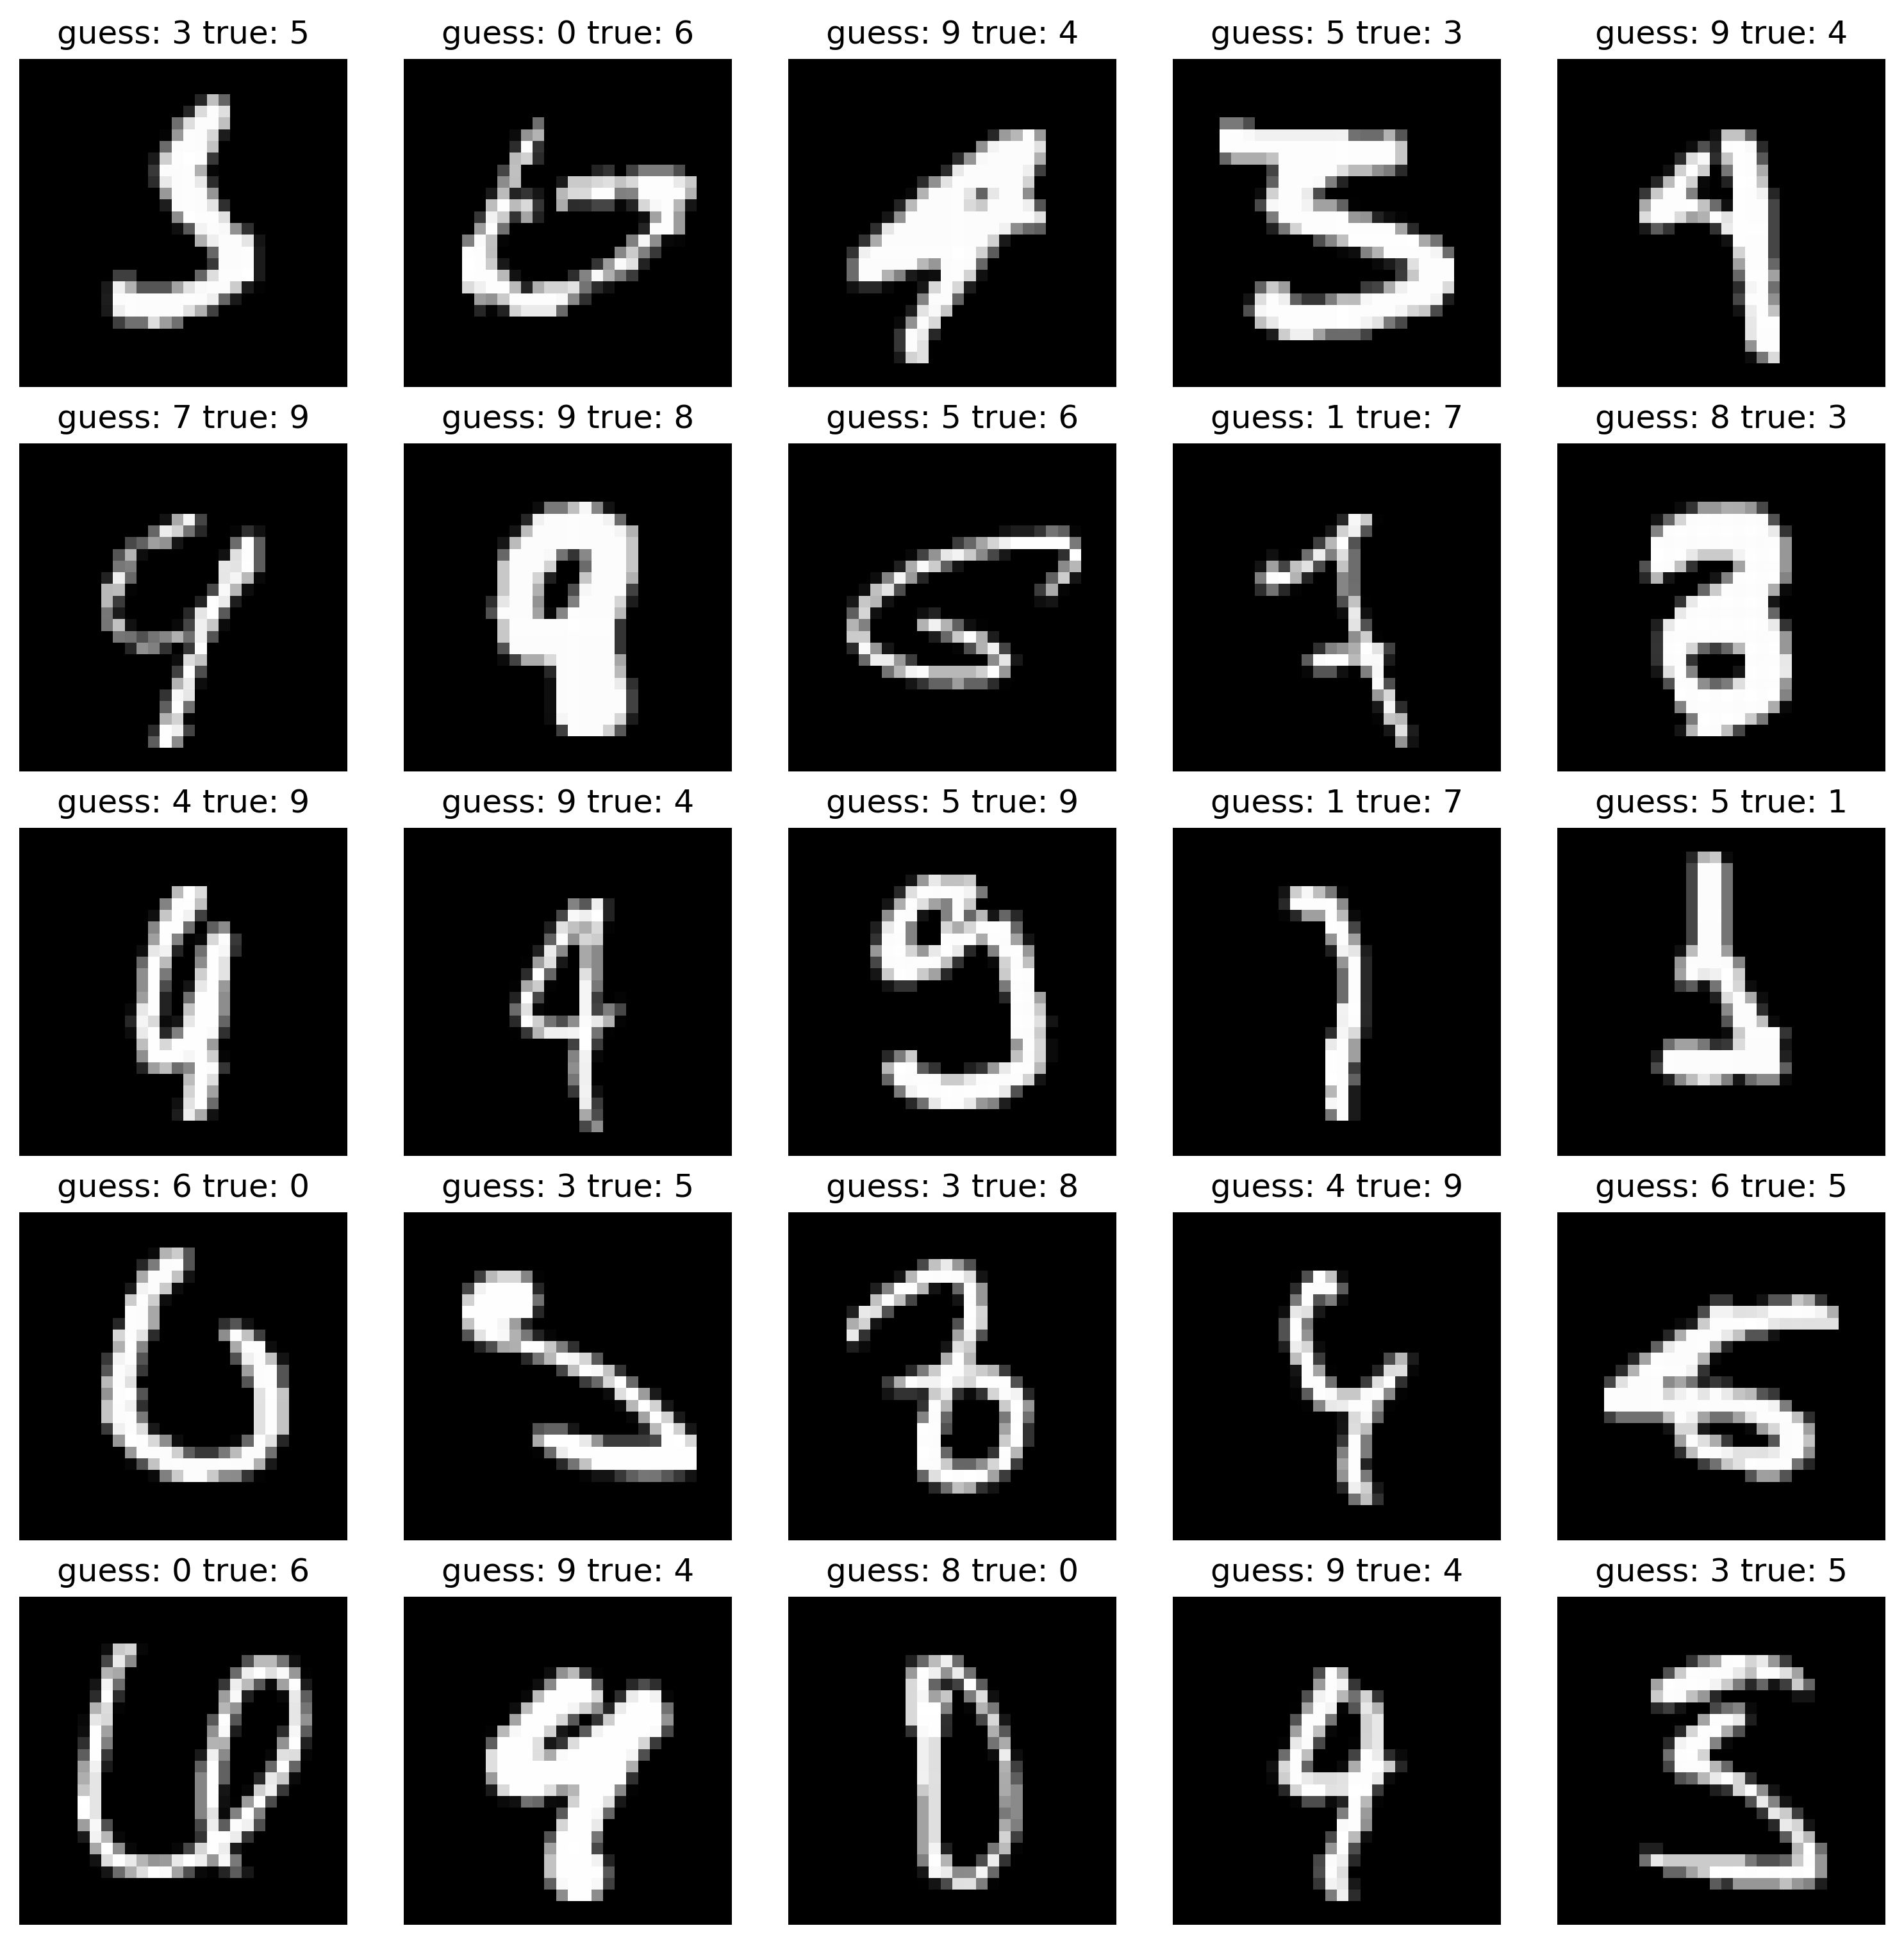

In [7]:
fig = plt.figure(dpi=300, figsize=(10, 10), constrained_layout=True)
plot_wrong_predictions(
    fig, big_results["adam_16_big_cnn"][0], x_test, y_test, 5, 5, verbose=verbosity
)
